In [ ]:
!pip install -Uq timm

In [ ]:
!pip install -Uq rasterio

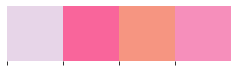

In [ ]:
import os
from glob import glob
from pprint import pprint
import random
import cv2
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import rasterio
from sklearn.model_selection import train_test_split

import timm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

colors = ['#E7D5E8','#F9659B','#F69581','#F68FBB']
sns.palplot(sns.color_palette(colors))

import warnings
warnings.filterwarnings("ignore")

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# plt.rc('xtick',labelsize=11)
# plt.rc('ytick',labelsize=11)

In [ ]:
config = dict(
    orig_train_dir = os.path.abspath('../input/mayo-clinic-strip-ai/train'),
    orig_test_dir = os.path.abspath('../input/mayo-clinic-strip-ai/test'),
    orig_other_dir = os.path.abspath('../input/mayo-clinic-strip-ai/other'),
    orig_train_csv_path =  os.path.abspath('../input/mayo-clinic-strip-ai/train.csv'),
    orig_test_csv_path = os.path.abspath('../input/mayo-clinic-strip-ai/test.csv'),
    orig_sample_submission_path = os.path.abspath('../input/mayo-clinic-strip-ai/sample_submission.csv'),
    orig_other_csv_path = os.path.abspath('../input/mayo-clinic-strip-ai/other.csv'),
    
    seed = 42, # here the seed is set to a random number 42 
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu',
    
    batch_size = 128,
    num_epochs=10,
    lr = 0.0003,
    
    use_wandb=False
)

In [ ]:
pprint(config) #pprint is used to write a data structure in such a way that it's readable(here the data structure is a dict)

{'batch_size': 128,
 'device': 'cuda:0',
 'lr': 0.0003,
 'num_epochs': 10,
 'orig_other_csv_path': '/input/mayo-clinic-strip-ai/other.csv',
 'orig_other_dir': '/input/mayo-clinic-strip-ai/other',
 'orig_sample_submission_path': '/input/mayo-clinic-strip-ai/sample_submission.csv',
 'orig_test_csv_path': '/input/mayo-clinic-strip-ai/test.csv',
 'orig_test_dir': '/input/mayo-clinic-strip-ai/test',
 'orig_train_csv_path': '/input/mayo-clinic-strip-ai/train.csv',
 'orig_train_dir': '/input/mayo-clinic-strip-ai/train',
 'seed': 42,
 'use_wandb': False}


In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config['seed'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/MyDrive/test.csv' '/content'
!cp -r '/content/drive/MyDrive/train.csv' '/content'
!cp -r '/content/drive/MyDrive/other.csv' '/content'
!cp -r '/content/drive/MyDrive/sample_submission.csv' '/content'

In [ ]:
train_data = pd.read_csv('train.csv')
display(train_data.head())

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [ ]:
print(f'Number of Training Samples: {train_data.shape[0]}')
print(f'Are there any missing values?: {train_data.isnull().values.any()}')  

Number of Training Samples: 754
Are there any missing values?: False


In [ ]:
test_data = pd.read_csv('test.csv')
display(test_data.head())

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0
2,00c058_0,11,00c058,0
3,01adc5_0,11,01adc5,0


In [ ]:
submission_data = pd.read_csv('sample_submission.csv')
display(submission_data.head())

,patient_id,CE,LAA
0,006388,0.5,0.5
1,008e5c,0.5,0.5
2,00c058,0.5,0.5
3,01adc5,0.5,0.5


In [ ]:
supplementary_data = pd.read_csv('other.csv')
display(supplementary_data.head())

,image_id,patient_id,image_num,other_specified,label
0,01f2b3_0,01f2b3,0,NaN,Unknown
1,01f2b3_1,01f2b3,1,NaN,Unknown
2,02ebd5_0,02ebd5,0,NaN,Unknown
3,0412ab_0,0412ab,0,NaN,Unknown
4,04414e_0,04414e,0,Hypercoagulable,Other


In [ ]:
id_to_label, label_to_id = {}, {}

for id, label in enumerate(train_data['label'].unique()):
    label_to_id[label] = id
    id_to_label[id] = label

train_data['label'] = train_data['label'].replace(label_to_id)

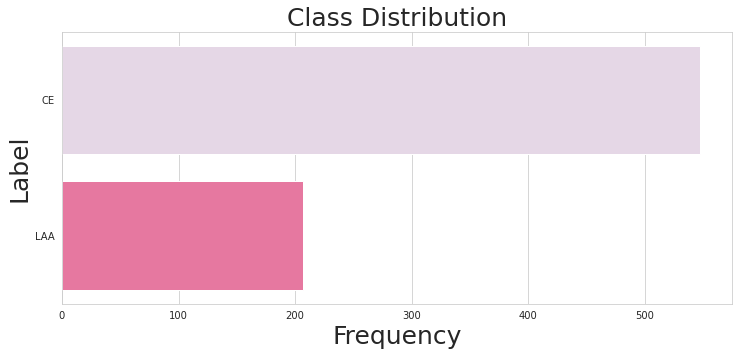

In [ ]:
type_distribution = train_data['label'].value_counts()
plt.figure(figsize=(12, 5))
sns.barplot(x=type_distribution.values, y=list(id_to_label.values()), palette=colors)
plt.title('Class Distribution', fontsize=25)
plt.xlabel('Frequency', fontsize=25)
plt.ylabel('Label', fontsize=25)
plt.show()

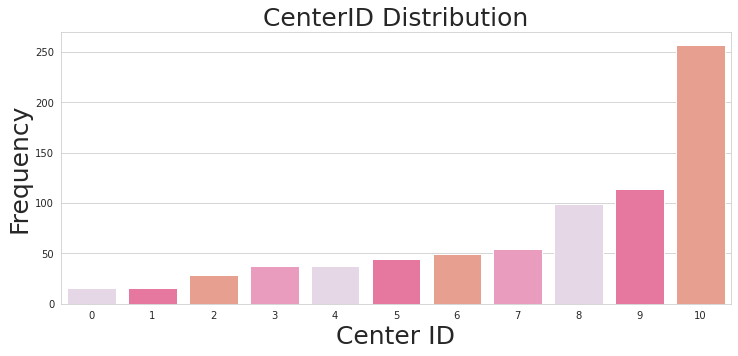

In [ ]:
center_distribution = train_data['center_id'].value_counts().sort_values(ignore_index=True)
plt.figure(figsize=(12, 5))
sns.barplot(x=center_distribution.index, y=center_distribution.values, palette=colors)
plt.title('CenterID Distribution', fontsize=25)
plt.xlabel('Center ID', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.show()

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"kkoundinyaa","key":"31e58c31a54d84325cbb974e0beaa17d"}
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alejopaullier/strip-ai-background-clot

100% 4.20G/4.20G [03:32<00:00, 18.7MB/s]
100% 4.20G/4.20G [03:32<00:00, 21.2MB/s]


In [ ]:
!ls

drive	   sample_data		  strip-ai-background-clot.zip	train.csv
other.csv  sample_submission.csv  test.csv


In [ ]:
!unzip -q ./strip-ai-background-clot.zip

In [ ]:
positive_df = pd.DataFrame(os.listdir('./positive'), columns=['filename'])
positive_df['filepath'] = positive_df['filename'].apply(lambda x: os.path.join('./positive', x))
positive_df['label'] = 1
positive_df.head()

,filename,filepath,label
0,0fcfe9_0-imgslice.2.9.jpg,./positive/0fcfe9_0-imgslice.2.9.jpg,1
1,028989_0-imgslice.28.3.jpg,./positive/028989_0-imgslice.28.3.jpg,1
2,09644e_2-imgslice.6.6.jpg,./positive/09644e_2-imgslice.6.6.jpg,1
3,0aff58_0-imgslice.20.3.jpg,./positive/0aff58_0-imgslice.20.3.jpg,1
4,0468a8_0-imgslice.39.3.jpg,./positive/0468a8_0-imgslice.39.3.jpg,1


In [ ]:
negative_df = pd.DataFrame(os.listdir('./negative'), columns=['filename'])
negative_df['filepath'] = negative_df['filename'].apply(lambda x: os.path.join('./negative', x))
negative_df['label'] = 0
negative_df.head()

,filename,filepath,label
0,0ba49d_0-imgslice.20.8.jpg,./negative/0ba49d_0-imgslice.20.8.jpg,0
1,112b6e_0-imgslice.8.5.jpg,./negative/112b6e_0-imgslice.8.5.jpg,0
2,0bddf9_0-imgslice.0.30.jpg,./negative/0bddf9_0-imgslice.0.30.jpg,0
3,00c058_0-imgslice.30.11.jpg,./negative/00c058_0-imgslice.30.11.jpg,0
4,0a3ad1_0-imgslice.4.14.jpg,./negative/0a3ad1_0-imgslice.4.14.jpg,0


In [ ]:
data = pd.concat([positive_df, negative_df]).sample(frac=1)
print(data.shape)
display(data.head(10))

(19998, 3)


,filename,filepath,label
6523,0415c3_0-imgslice.50.3.jpg,./negative/0415c3_0-imgslice.50.3.jpg,0
4307,0d93ce_0-imgslice.17.4.jpg,./positive/0d93ce_0-imgslice.17.4.jpg,1
3353,0b7871_1-imgslice.8.8.jpg,./positive/0b7871_1-imgslice.8.8.jpg,1
7038,112b6e_0-imgslice.2.19.jpg,./positive/112b6e_0-imgslice.2.19.jpg,1
8288,0a3ad1_0-imgslice.9.2.jpg,./positive/0a3ad1_0-imgslice.9.2.jpg,1
2214,0468a8_1-imgslice.25.22.jpg,./positive/0468a8_1-imgslice.25.22.jpg,1
7970,129102_0-imgslice.0.6.jpg,./negative/129102_0-imgslice.0.6.jpg,0
1087,037300_0-imgslice.8.10.jpg,./positive/037300_0-imgslice.8.10.jpg,1
1049,0aff58_0-imgslice.17.6.jpg,./negative/0aff58_0-imgslice.17.6.jpg,0
3649,028989_0-imgslice.20.6.jpg,./positive/028989_0-imgslice.20.6.jpg,1


In [ ]:
def check_background(filepath, threshold=10, display=False, ax=None):
    image = cv2.imread(filepath)
    print(image.shape)
    h, w, _ = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

    pixels = cv2.countNonZero(thresh)
    ratio = (pixels/(h * w)) * 100
    #print('Pixel ratio: {:.2f}%'.format(ratio))
    roi = 0
    if ratio >= threshold:
        roi = 1
    
    if display and ax is not None:
        ax.imshow(thresh)
        ax.set_title('Mostly Background' if not roi else 'Contains region of interest', fontsize=14)
        ax.axis('off')
    
    return roi

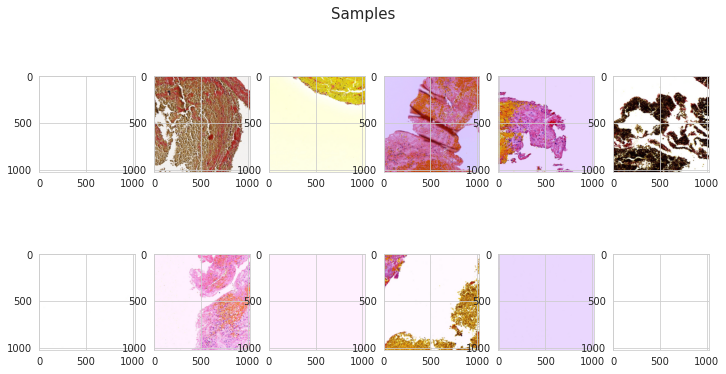

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12,6))
plt.suptitle("Samples", fontsize = 15)

for i in range(0, 2*6):
    image = cv2.imread(data['filepath'].values[i])
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone)
    #axes[x, y].axis('off')

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


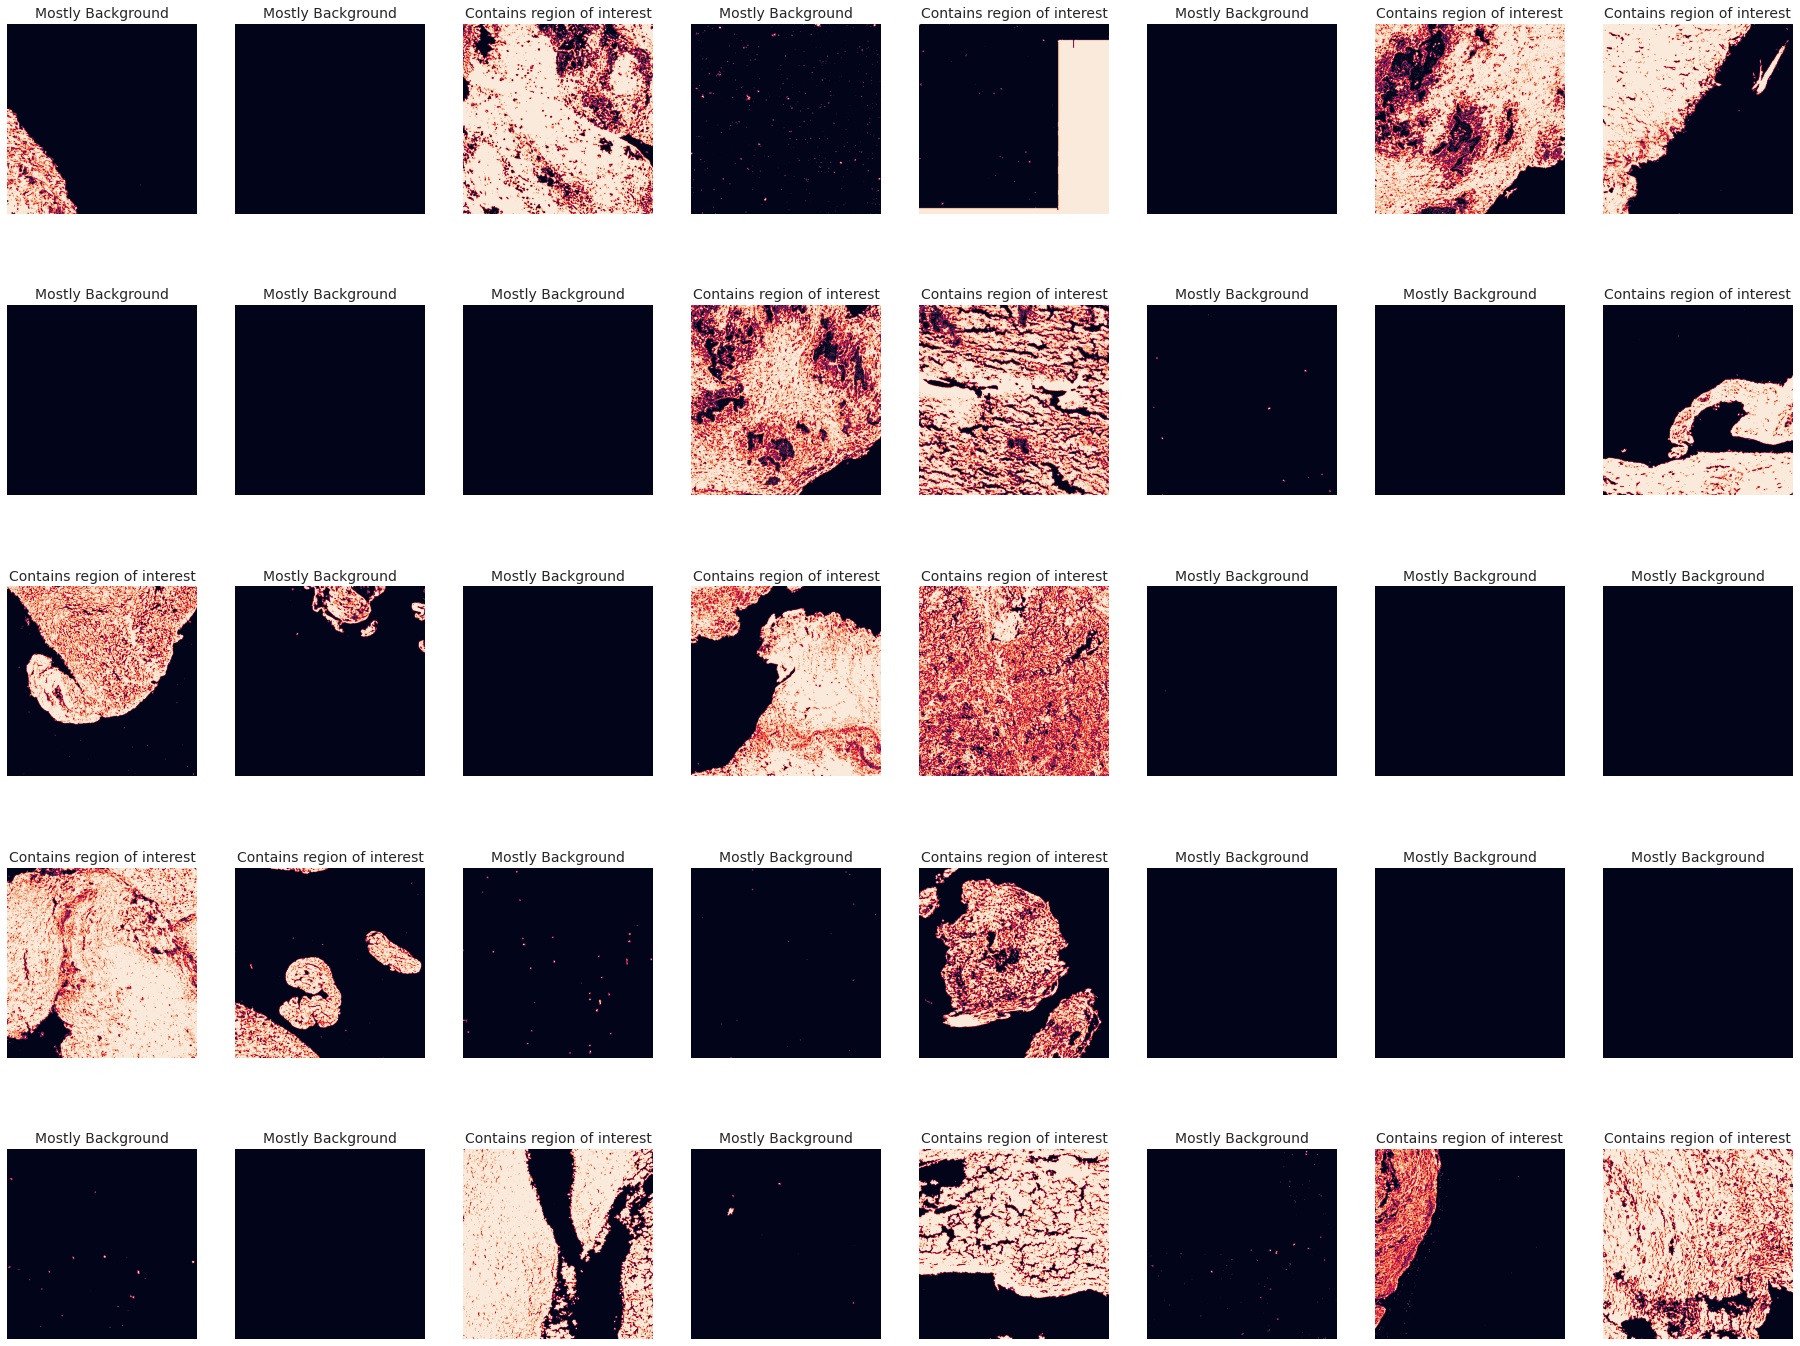

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(32,25))

for i in range(0, 5*8):
    x = i // 8
    y = i % 8
    check_background(data['filepath'].values[np.random.randint(0, len(data))], 10, True, axes[x, y])

In [ ]:

preds = Parallel(n_jobs=-1)(delayed(check_background)(data['filepath'].values[i], 5) for i in tqdm(range(len(data))))
print(f'Accuracy: {accuracy_score(preds, data["label"].values)}')

  0%|          | 0/19998 [00:00<?, ?it/s]

Accuracy: 0.9554955495549555


In [ ]:
!mkdir ~/.Kaggle3
!touch ~/.kaggle/kaggle.json

api_token = {"username":"kkoundinyaa","key":"31e58c31a54d84325cbb974e0beaa17d"}
import json

with open('/root/./Kaggle3.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d robikscube/mayo-clinic-1024-jpg-part1

100% 6.07G/6.07G [05:11<00:00, 23.8MB/s]
100% 6.07G/6.07G [05:11<00:00, 20.9MB/s]


In [ ]:
!ls

drive				sample_data
mayo-clinic-1024-jpg-part1.zip	sample_submission.csv
metadata.csv			strip-ai-background-clot.zip
negative			test.csv
other.csv			train.csv
positive


In [ ]:
!unzip -q ./mayo-clinic-1024-jpg-part1.zip

In [ ]:
pwd

In [ ]:
df = pd.DataFrame(glob('train/*.jpg'), columns=['filepath'])
df['image_id'] = df['filepath'].apply(lambda x: x.split('/')[-1].split('-')[0])
df = df.merge(train_data, on='image_id', how='left')
df = df.drop(['image_id', 'center_id', 'image_num', 'patient_id'], axis=1)

print(f'Number of Training Samples: {df.shape[0]}')
display(df.head(10))

Number of Training Samples: 60090


,filepath,label
0,train/04f7a4_0-imgslice.4.8.jpg,0
1,train/037300_0-imgslice.27.14.jpg,0
2,train/0fcfe9_0-imgslice.2.9.jpg,1
3,train/0d93ce_0-imgslice.29.28.jpg,0
4,train/0ba49d_0-imgslice.55.20.jpg,0
5,train/049194_1-imgslice.4.3.jpg,0
6,train/0ba49d_0-imgslice.20.8.jpg,0
7,train/0d533f_0-imgslice.19.15.jpg,0
8,train/112b6e_0-imgslice.8.5.jpg,0
9,train/037300_0-imgslice.47.15.jpg,0


In [ ]:
is_background = Parallel(n_jobs=-1)(delayed(check_background)(df['filepath'].values[i], 5) 
for i in tqdm(range(len(df))))
df['is_background'] = is_background
df.to_csv('dataset.csv', index=False)

  0%|          | 0/60090 [00:00<?, ?it/s]

In [ ]:
data = df

In [ ]:
print('Percentage of Background Images in sliced dataset: {:.3f}'.format(data[data["is_background"] == 0].count()[0] / len(data) * 100))

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(30,20))
plt.suptitle("Background patches", fontsize = 16)

background_images = data[data["is_background"] == 0]

for i in range(0, 3*6):
    x = i // 6
    y = i % 6
    image = cv2.imread(background_images.sample(1)['filepath'].values[0])
    axes[x, y].imshow(image, cmap=plt.cm.bone)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(30,20))
plt.suptitle("Non-Background patches", fontsize = 16)

roi_images = data[data["is_background"] == 1]

for i in range(0, 3*6):
    x = i // 6
    y = i % 6
    image = cv2.imread(roi_images.sample(1)['filepath'].values[0])
    axes[x, y].imshow(image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

In [ ]:
data = data.loc[data['is_background'] != 0]
print(data.shape)

KeyError: ignored

In [ ]:
type_distribution = data['label'].value_counts()
plt.figure(figsize=(20, 5))
sns.barplot(x=type_distribution.values, y=list(id_to_label.values()), palette=colors)
plt.title('Class Distribution', fontsize=25)
plt.xlabel('Frequency', fontsize=25)
plt.ylabel('Label', fontsize=25)
plt.show()

In [ ]:
class ClinicDataset(Dataset):
    def __init__(self, df, transforms=None, is_test=False):
        self.df = df
        self.transforms = transforms
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = Image.open(self.df['filepath'].values[idx])

        if transforms is not None:
            image = self.transforms(image)
        
        if self.is_test:
            return image
        
        label = torch.tensor(self.df['label'].values[idx], dtype=torch.float)

        return image, label

In [ ]:
model = timm.create_model('densenet121', pretrained=True, num_classes=1)
torch.nn.functional.sigmoid(model(torch.randn(4, 3, 512, 512)))

tensor([[0.4766],
        [0.5449],
        [0.5338],
        [0.5491]], grad_fn=<SigmoidBackward0>)

In [ ]:
# model = timm.create_model('resnet18', pretrained = True,  num_classes = 1)
# torch.nn.functional.sigmoid(model(torch.randn(4, 3, 512, 512)))

tensor([[0.6846],
        [0.6700],
        [0.6258],
        [0.6836]], grad_fn=<SigmoidBackward0>)

In [ ]:
input_shape = torch.randn(4, 3, 512, 512)
model(input_shape).shape

In [ ]:
num_in_features = model.get_classfier().in_features; num_in_features

In [ ]:
model.global_pool

In [ ]:
model.classifier = nn.Sequential(
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)
model(torch.randn(4, 3, 512, 512))

tensor([[0.5731],
        [0.8323],
        [0.8082],
        [0.4560]], grad_fn=<AddmmBackward0>)

In [ ]:
def fit(model, dataset, dataloader, optim, criterion, mode='train'):
    # Choice of training and testing mode
    if mode == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_corrects = 0.0

    tqdm_loop = tqdm(
        dataloader,
        total=len(dataset) // dataloader.batch_size,
        desc=mode, leave=True
    )

    # Loop over the dataloader and train over every batch of images
    for i, data in enumerate(tqdm_loop):
        # Copy data to the gpu
        images, labels = data
        images, labels = images.to(config['device']), labels.to(config['device'])
        
        # Zero the parameter gradients during training
        if mode=='train':
            optim.zero_grad()

        # Predict classes using images from the training set
        outputs = model(images)

        # Compute the loss based on model output and real labels
        loss = criterion(outputs.squeeze(1), labels)

        # Calculate statistics
        running_loss += loss
        running_corrects += (outputs.max(1)[1] == labels).sum()
        
        # Perform model updates according to the loss function (criterion)
        if mode=='train':
            # Backpropagate the loss
            loss.backward()
            # Adjust parameters based on the calculated gradients
            optim.step()
    
    # Record the average statistics
    epoch_loss = running_loss / dataset.__len__()
    epoch_acc = running_corrects / dataset.__len__()
    
    tqdm_loop.set_postfix(loss=epoch_loss, acc=epoch_acc)

    return epoch_loss, epoch_acc

In [ ]:
n0 = data.loc[data['label'] == 1].shape[0]
n1 = data.loc[data['label'] == 1].shape[0]

w0 = 1 - n0/(n0+n1)
w1 = 1 - n1/(n0+n1)

class_weights=torch.FloatTensor([w0, w1]).to(config['device'])

optim = torch.optim.AdamW(model.parameters(), lr=config['lr'])
loss_fn = torch.nn.BCELoss()

In [ ]:
train_df, valid_df = train_test_split(data[:50], test_size=0.2)

print(train_df.shape, valid_df.shape)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((512, 512)),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(10),
#         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.ToTensor(),
        
    ]),
    'valid': transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
}

train_dataset = ClinicDataset(train_df, transforms=data_transforms['train'])
valid_dataset = ClinicDataset(valid_df, transforms=data_transforms['valid'])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True, drop_last=True)

(40, 3) (10, 3)


In [ ]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
best_acc = 0

# Run train loop for given number of epochs
for epoch in range(config['num_epochs']):
    print(f'\nEpoch: {epoch+1} / {config["num_epochs"]}')
    print('-' * 10)

    # Train model one epoch and display statistics
    train_epoch_loss, train_epoch_acc = fit(model.to(config['device']), train_dataset, train_dataloader, optim, loss_fn, mode='train')
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    print(f'Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.4f}')

    # Run validation for one epoch and display statistics
    with torch.no_grad():
        valid_epoch_loss, valid_epoch_acc = fit(model.to(config['device']), valid_dataset, valid_dataloader, optim, loss_fn, mode='valid')
        valid_loss.append(valid_epoch_loss)
        valid_acc.append(valid_epoch_acc)
        print(f'Valid Loss: {valid_epoch_loss:.4f} | Valid Acc: {valid_epoch_acc:.4f}')

    if config['use_wandb']:
        wandb.log({
            "train_loss": train_epoch_loss,
            "valid_loss": valid_epoch_loss,
            "train_acc": train_epoch_acc,
            "valid_acc": valid_epoch_acc,

        })
    
    if valid_epoch_acc >= best_acc:
        print(f'Model improved from {best_acc} to {valid_epoch_acc}, Saving best model...')
        torch.save(model.state_dict(), f'efficientnet_b0_{valid_epoch_acc:.4f}.pt')
        best_acc = valid_epoch_acc

checkpoint = {
            'total_epochs'      : config['num_epochs'],
            'state_dict'        : model.state_dict(),
            'optimizer'         : optim.state_dict(),
            'train_loss'        : train_loss,
            'train_acc'         : train_acc,
            'val_loss'          : valid_loss,
            'val_acc'           : valid_acc,
            }

torch.save(checkpoint, 'last_checkpoint.pt')
print("Model Saved")


Epoch: 1 / 10
----------


train:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
print(torch.__version__)

1.13.1+cu116


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
